In [1]:
from pandas import read_csv
# from pandas import datetime
import pandas as pd
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA 
from sklearn.metrics import mean_squared_error 

In [2]:
df = pd.read_csv('shampoo-sales.csv',parse_dates=["Month"], index_col="Month")

In [3]:
df.head()

,Sales
Month,
01-01,266.0
01-02,145.9
01-03,183.1
01-04,119.3
01-05,180.3


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38 entries, 01-01 to Sales of shampoo over a three year period
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Sales   36 non-null     float64
dtypes: float64(1)
memory usage: 608.0+ bytes


In [5]:
df.isnull().sum()

Sales    2
dtype: int64

In [6]:
df.dropna(inplace=True)

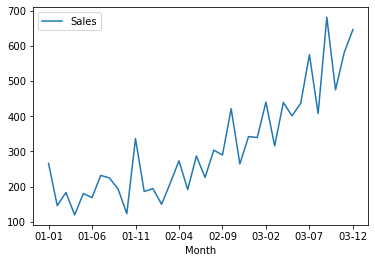

In [7]:
df.plot()
pyplot.show()

From here we can see that Shampoo sales data has a clear trend, that means time series is not stationary and will require differencing to make it stationary.Another way to check stationary data is dicky fuller test. so we are trying that method also.

In [8]:
# H0 :- it is not stationary
# H1 :- it is stationary
from statsmodels.tsa.stattools import adfuller

def ad_test(dataset):
    dftest=adfuller(dataset,autolag='AIC')
    print("1. ADF  :",dftest[0])
    print("2. P- value  :",dftest[1])
    print("3.num of lags  :",dftest[2])
    print("4. num of observation  used for ADF regression and critical value calculation  :",dftest[3])
    print("5. critical value  :")
    for key,val in dftest[4].items():
        print("\t",key," :",val)
    if dftest[1]<=0.05:
        print("rejecting the null hypothesis, it is stationary")
    else:
        print("it is not stationary")

In [9]:
ad_test(df['Sales'])

1. ADF  : 3.0601420836411806
2. P- value  : 1.0
3.num of lags  : 10
4. num of observation  used for ADF regression and critical value calculation  : 25
5. critical value  :
	 1%  : -3.7238633119999998
	 5%  : -2.98648896
	 10%  : -2.6328004
it is not stationary


to make it stationary we are using differencing technique

In [10]:
df["sales_diff"]=df["Sales"]- df["Sales"].shift(1)

In [11]:
df.head(6)

,Sales,sales_diff
Month,,
01-01,266.0,NaN
01-02,145.9,-120.1
01-03,183.1,37.2
01-04,119.3,-63.8
01-05,180.3,61.0
01-06,168.5,-11.8


In [12]:
ad_test(df['sales_diff'].dropna())

1. ADF  : -7.249074055553854
2. P- value  : 1.7998574141687034e-10
3.num of lags  : 1
4. num of observation  used for ADF regression and critical value calculation  : 33
5. critical value  :
	 1%  : -3.6461350877925254
	 5%  : -2.954126991123355
	 10%  : -2.6159676124885216
rejecting the null hypothesis, it is stationary


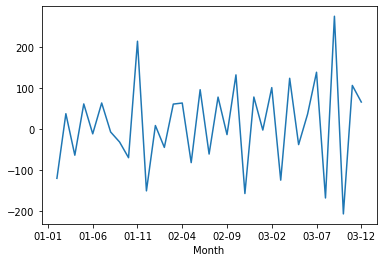

In [13]:
df['sales_diff'].plot()

now are data is stationary

using ACF and PACF to find out the value of p,d,q

p is auto regressive d is differencing q is moving average

C:\Users\poona\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


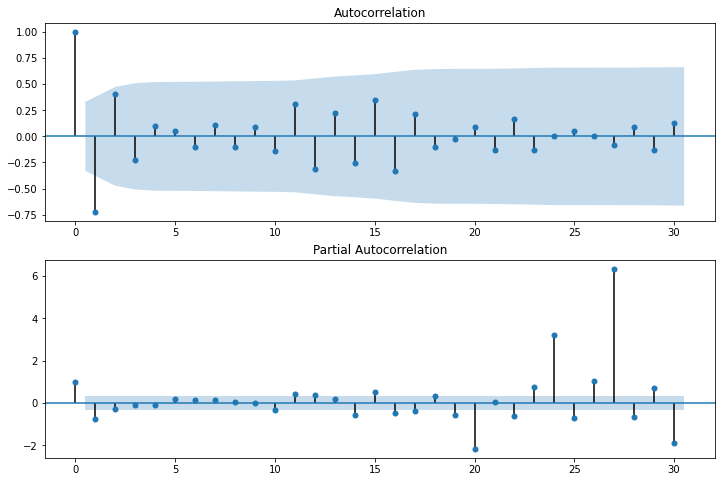

In [14]:
# show plots in the notebook
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df["sales_diff"].iloc[1:], lags=30, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df["sales_diff"].iloc[1:], lags=30, ax=ax2)

In [15]:
X = df['sales_diff'].dropna().values
X

array([-120.1,   37.2,  -63.8,   61. ,  -11.8,   63.3,   -7.3,  -31.7,
        -69.9,  213.6, -150.6,    8.4,  -44.8,   60.6,   63.2,  -81.9,
         95.6,  -61. ,   77.6,  -13.7,  131.7, -157.1,   77.8,   -2.6,
        100.7, -124.5,  123.4,  -38. ,   36.1,  138.1, -167.9,  274.4,
       -206.7,  106. ,   65.6])

In [16]:
size = int(len(X) * 0.66)

In [17]:
size

23

In [18]:
train, test = X[0:size], X[size:len(X)]

In [19]:
len(train)

23

In [20]:
history = [x for x in train]

In [21]:
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

predicted=0.022788, expected=-2.600000
predicted=75.875538, expected=100.700000
predicted=-60.981785, expected=-124.500000
predicted=77.801431, expected=123.400000
predicted=-60.424580, expected=-38.000000
predicted=96.315543, expected=36.100000
predicted=-16.149093, expected=138.100000
predicted=-70.299947, expected=-167.900000
predicted=163.027853, expected=274.400000
predicted=-152.045607, expected=-206.700000
predicted=245.450412, expected=106.000000
predicted=32.688300, expected=65.600000
Test MSE: 6675.392


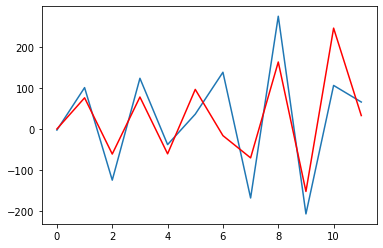

In [22]:
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

now we can say our actual and predicted values are same